# GIUH test

In [1]:
import torch

In [21]:
num_giuh_ordinates = 5
giuh_ordinates = torch.tensor([0.1, 0.2, 0.4, 0.2, 0.1])
runoff_queue_m_per_timestep = torch.zeros(len(giuh_ordinates)+1)
surface_runoff_depth_m = torch.tensor(2.0)

In [22]:
N = num_giuh_ordinates

runoff_queue_m_per_timestep[N] = torch.tensor(0.0, dtype=torch.float)

for i in range(num_giuh_ordinates): 

    runoff_queue_m_per_timestep[i] = runoff_queue_m_per_timestep[i] + giuh_ordinates[i] * surface_runoff_depth_m
    
flux_giuh_runoff_m = runoff_queue_m_per_timestep[0]

# __________________________________________________________________
# shift all the entries in preperation for the next timestep

for i in range(num_giuh_ordinates): 
    runoff_queue_i_minus_1 = runoff_queue_m_per_timestep[i+1]
    runoff_queue_m_per_timestep[i] = runoff_queue_i_minus_1
    
runoff_queue_m_per_timestep

tensor([0.4000, 0.8000, 0.4000, 0.2000, 0.0000, 0.0000])

In [23]:
torch_sum = torch.sum(runoff_queue_m_per_timestep)
torch_sum

tensor(1.8000)

In [25]:
import numpy as np
num_giuh_ordinates = 5
giuh_ordinates = [0.1, 0.2, 0.4, 0.2, 0.1]
runoff_queue_m_per_timestep = np.zeros(len(giuh_ordinates)+1)
surface_runoff_depth_m = 2

In [26]:
N = num_giuh_ordinates

runoff_queue_m_per_timestep[N] = 0.0


for i in range(num_giuh_ordinates): 

    runoff_queue_m_per_timestep[i] += giuh_ordinates[i] * surface_runoff_depth_m
    
flux_giuh_runoff_m = runoff_queue_m_per_timestep[0]

# __________________________________________________________________
# shift all the entries in preperation for the next timestep

for i in range(num_giuh_ordinates): 
    runoff_queue_m_per_timestep[i] = runoff_queue_m_per_timestep[i+1]

runoff_queue_m_per_timestep

array([0.4, 0.8, 0.4, 0.2, 0. , 0. ])

In [16]:
np_sum = sum(runoff_queue_m_per_timestep)
np_sum

1.8

In [24]:
np_sum - torch_sum

tensor(-1.1921e-07)

# Test soil ODE

https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html  
https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py

In [54]:
import torch
import numpy as np
import argparse
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchdiffeq import odeint, odeint_adjoint
from torchdiffeq import odeint_event

torch.set_default_dtype(torch.float64)

In [64]:
class soil_moisture_flux_ode(nn.Module):
    
    def __init__(self, cfe_state=None, reservoir=None):
        super().__init__()
        self.cfe_state = cfe_state
        self.reservoir = reservoir

    def forward(self, t, states):
        
        S = states[0]
            
        storage_above_threshold_m = S - reservoir['storage_threshold_primary_m']
        storage_diff = reservoir['storage_max_m'] - reservoir['storage_threshold_primary_m']
        storage_ratio = torch.minimum(storage_above_threshold_m / storage_diff, torch.tensor([1.0]))

        perc_lat_switch = torch.multiply(S - reservoir['storage_threshold_primary_m'] > 0, 1)
        ET_switch = torch.multiply(S - reservoir['wilting_point_m'] > 0, 1)

        storage_above_threshold_m_paw = S - reservoir['wilting_point_m']
        storage_diff_paw = reservoir['storage_threshold_primary_m'] - reservoir['wilting_point_m']
        storage_ratio_paw = torch.minimum(storage_above_threshold_m_paw / storage_diff_paw, torch.tensor([0.3])) # Equation 11 (Ogden's document)
        dS_dt = cfe_state['infiltration_depth_m'] -1 * perc_lat_switch * (reservoir['coeff_primary'] + reservoir['coeff_secondary']) * storage_ratio - ET_switch * cfe_state['reduced_potential_et_m_per_timestep'] * storage_ratio_paw
        
        return (dS_dt)

In [65]:

# Initialization
y0 = torch.tensor([0.3])
t = torch.tensor([0, 0.05, 0.15, 0.3, 0.6, 1.0]) # ODE time descritization of one time step
cfe_state = {}
cfe_state['infiltration_depth_m'] = torch.tensor([0.1])
cfe_state['reduced_potential_et_m_per_timestep'] = torch.tensor([0.003])
reservoir = {}
reservoir['storage_threshold_primary_m'] = torch.tensor([0.2])
reservoir['storage_max_m'] = torch.tensor([0.4])
reservoir['wilting_point_m'] = torch.tensor([0.1])
reservoir['coeff_primary'] = torch.tensor([0.4])
reservoir['coeff_secondary'] = torch.tensor([0.4])

# Pass parameters beforehand
device = 'cpu'
func = soil_moisture_flux_ode(cfe_state=cfe_state, reservoir=reservoir).to(device)

# Solve and ODE
sol = odeint(
    func,
    y0,
    t,
    atol=1e-5,
    rtol=1e-5,
    # adjoint_params=()
)



In [85]:
sol.shape

torch.Size([6, 1])

In [93]:
# Finalize results
ts_concat = t
ys_concat = sol.squeeze()
t_proportion = torch.diff(ts_concat, dim=0) # ts_concat[1:] - ts_concat[:-1]
ys_concat

tensor([0.3000, 0.2864, 0.2661, 0.2474, 0.2316, 0.2262])

In [112]:
import torch.nn.functional as F

# Create the kernel tensor with torch.ones
kernel = torch.ones(2)

# Get the moving average y values in between the time intervals
convolved = F.conv1d(ys_concat.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1).squeeze()
# Divide by 2 to match np.convolve
ys_avg_ = convolved / 2
ys_avg = ys_avg_[1:-1]
ys_avg
# Original numpy method
# ys_avg = np.convolve(ys_concat, np.ones(2), 'valid') / 2

tensor([0.2932, 0.2762, 0.2567, 0.2395, 0.2289])

In [111]:
import math
lateral_flux = torch.zeros(ys_avg.shape)
perc_lat_switch = ys_avg - reservoir['storage_threshold_primary_m'] > 0
lateral_flux[perc_lat_switch] = reservoir['coeff_secondary'] * torch.minimum(
    (ys_avg[perc_lat_switch] - reservoir['storage_threshold_primary_m']) / (
                reservoir['storage_max_m'] - reservoir['storage_threshold_primary_m']), torch.tensor([1.0]))
lateral_flux_frac = lateral_flux * t_proportion

perc_flux = torch.zeros(ys_avg.shape)
perc_flux[perc_lat_switch] = reservoir['coeff_primary'] * torch.minimum(
    (ys_avg[perc_lat_switch] - reservoir['storage_threshold_primary_m']) / (
                reservoir['storage_max_m'] - reservoir['storage_threshold_primary_m']), torch.tensor([1.0]))
perc_flux_frac = perc_flux * t_proportion

et_from_soil = torch.zeros(ys_avg.shape)
ET_switch = ys_avg - reservoir['wilting_point_m'] > 0
et_from_soil[ET_switch] = cfe_state['reduced_potential_et_m_per_timestep'] * torch.minimum(
    (ys_avg[ET_switch] - reservoir['wilting_point_m']) / (reservoir['storage_threshold_primary_m'] - reservoir['wilting_point_m']), torch.tensor([1.0]))
et_from_soil_frac = et_from_soil * t_proportion

infilt_to_soil = cfe_state['infiltration_depth_m'].repeat(ys_avg.shape)
infilt_to_soil_frac = infilt_to_soil * t_proportion

# Scale fluxes (Since the sum of all the estimated flux above usually exceed the input flux because of calculation errors, scale it
# The more finer ODE time descritization you use, the less errors you get, but the more calculation time it takes 
sum_outflux = lateral_flux_frac + perc_flux_frac + et_from_soil_frac
if sum_outflux.any() == 0:
    flux_scale = 0
else:
    flux_scale = torch.zeros(infilt_to_soil_frac.shape)
    flux_scale[sum_outflux != 0] = (torch.diff(-ys_concat, dim=0)[sum_outflux != 0] + infilt_to_soil_frac[
        sum_outflux != 0]) / sum_outflux[sum_outflux != 0]
    flux_scale[sum_outflux == 0] = 0
scaled_lateral_flux = lateral_flux_frac * flux_scale
scaled_perc_flux = perc_flux_frac * flux_scale
scaled_et_flux = et_from_soil_frac * flux_scale

# Pass the results
# ? Do these all gets tracked? 
primary_flux_m = math.fsum(scaled_perc_flux)
secondary_flux_m = math.fsum(scaled_lateral_flux)
actual_et_from_soil_m_per_timestep = math.fsum(scaled_et_flux)
reservoir['storage_m'] = ys_concat[-1]

print(f'primary_flux_m: {primary_flux_m}')
print(f'secondary_flux_m: {secondary_flux_m}')
print(f'actual_et_from_soil_m_per_timestep: {actual_et_from_soil_m_per_timestep}')
print(f'reservoir["storage_m"]: {reservoir["storage_m"]}')

# cfe_state.primary_flux_m = math.fsum(scaled_perc_flux)
# cfe_state.secondary_flux_m = math.fsum(scaled_lateral_flux)
# cfe_state.actual_et_from_soil_m_per_timestep = math.fsum(scaled_et_flux)
# # reservoir['storage_m'] = ys_concat[-1]
# cfe_state.soil_reservoir['storage_m'] = ys_concat[-1]

primary_flux_m: 0.08548009648611235
secondary_flux_m: 0.08548009648611235
actual_et_from_soil_m_per_timestep: 0.0028869109589852553
reservoir["storage_m"]: 0.22615289606879002


# Test nash cascade

In [1]:
import torch

In [2]:
num_lateral_flow_nash_reservoirs = 2
K_nash = 0.3

In [68]:
nash_storage = torch.tensor([0,0], dtype=torch.float)
for t in range(5):
    
    flux_lat_m = torch.tensor(0.3, dtype=torch.float)
    Q = torch.zeros(num_lateral_flow_nash_reservoirs)
    for i in range(num_lateral_flow_nash_reservoirs):
        
        if i != 0:
            # For the next reservoir
            Q_i_mnus_1 = Q_i


        # Calculate the discharge from nash storage[i]
        Q[i] = K_nash * nash_storage[i]
        
        # Current Q_i
        Q_i = Q[i]

        # Subtract the discharge from the nash storage [i]
        nash_storage[i] = nash_storage[i] - Q_i

        # The first storage gets the lateral flow from soil
        if i == 0:
            nash_storage[i] = nash_storage[i] + flux_lat_m
        # The remaining storage receives the discharge from nash storage [i-1]
        else:
            nash_storage[i] = nash_storage[i] + Q_i_mnus_1 #Q[i-1]

    
    # The final discharge at the timestep from nash cascade is Q[cfe_state.num_lateral_flow_nash_reservoirs-1]
    flux_nash_lateral_runoff_m = Q_i #Q[cfe_state.num_lateral_flow_nash_reservoirs - 1]
    print(f'Nash   :{nash_storage}')
    print(f'Q      :{Q_i_mnus_1, Q_i}')

Nash   :tensor([0.3000, 0.0000])
Q      :(tensor(0.), tensor(0.))
Nash   :tensor([0.5100, 0.0900])
Q      :(tensor(0.0900), tensor(0.))
Nash   :tensor([0.6570, 0.2160])
Q      :(tensor(0.1530), tensor(0.0270))
Nash   :tensor([0.7599, 0.3483])
Q      :(tensor(0.1971), tensor(0.0648))
Nash   :tensor([0.8319, 0.4718])
Q      :(tensor(0.2280), tensor(0.1045))


In [5]:
nash_storage = torch.tensor([0,0], dtype=torch.float)
for t in range(5):
    # Reset the discharge from nash cascades
    flux_lat_m = torch.tensor(0.3, dtype=torch.float)
    Q = torch.zeros(num_lateral_flow_nash_reservoirs)

    # Loop through the nash reservoir
    for i in range(num_lateral_flow_nash_reservoirs):
        
        if i != 0:
            # Save this variable for the lower nash storage
            Q_i_mnus_1 = Q_i

        # Clone the variable for gradient tracking 
        n_i = nash_storage[i].clone()
        Q_i = Q[i].clone()
        
        # Calculate the discharge Q[i] from nash storage[i]
        Q_i = K_nash * n_i

        # Subtract the discharge Q[i] from the nash storage [i]
        n_i = n_i - Q_i

        # The first storage gets the lateral flow from soil
        if i == 0:
            n_i = n_i + flux_lat_m
        # The remaining storage receives the discharge from upper nash storage Q[i-1]
        else:
            n_i = n_i + Q_i_mnus_1
            
        # Clone back the variable for gradient tracking 
        Q[i] = Q_i.clone()
        nash_storage[i] = n_i.clone()

    # The final discharge at the timestep from nash cascade is from the lowermost nash storage
    flux_nash_lateral_runoff_m = Q_i
    print(f'Nash   :{nash_storage}')
    print(f'Q      :{Q_i_mnus_1, Q_i}')

Nash   :tensor([0.3000, 0.0000])
Q      :(tensor(0.), tensor(0.))
Nash   :tensor([0.5100, 0.0900])
Q      :(tensor(0.0900), tensor(0.))
Nash   :tensor([0.6570, 0.2160])
Q      :(tensor(0.1530), tensor(0.0270))
Nash   :tensor([0.7599, 0.3483])
Q      :(tensor(0.1971), tensor(0.0648))
Nash   :tensor([0.8319, 0.4718])
Q      :(tensor(0.2280), tensor(0.1045))


In [81]:
import numpy as np

num_lateral_flow_nash_reservoirs = 2
K_nash = 0.3


In [82]:
nash_storage_np = np.zeros(num_lateral_flow_nash_reservoirs)
for t in range(5):
    Q = np.zeros(num_lateral_flow_nash_reservoirs)
    flux_lat_m = 3

    for i in range(num_lateral_flow_nash_reservoirs):
        
        Q[i] = K_nash * nash_storage_np[i]
        
        
        nash_storage_np[i] -= Q[i]
        
        if i == 0:
            nash_storage_np[i] += flux_lat_m
        else:
            nash_storage_np[i] += Q[i-1]

    flux_nash_lateral_runoff_m = Q[num_lateral_flow_nash_reservoirs - 1]
    print(f'Nash:{nash_storage_np}')
    print(f'Q   :{Q_i_mnus_1, Q_i}')


Nash:[3. 0.]
Q   :(2.2797, 1.0449)
Nash:[5.1 0.9]
Q   :(2.2797, 1.0449)
Nash:[6.57 2.16]
Q   :(2.2797, 1.0449)
Nash:[7.599 3.483]
Q   :(2.2797, 1.0449)
Nash:[8.3193 4.7178]
Q   :(2.2797, 1.0449)


# Plot results

In [17]:
import pandas as pd

In [18]:
testrun_numpy = pd.read_csv(r'G:\Shared drives\SI_NextGen_Aridity\dCFE\output\testrun_numpy_classic.csv', header=None)
testrun_numpy.head()

,0,1
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN


In [19]:
testrun_torch = pd.read_csv(r'G:\Shared drives\SI_NextGen_Aridity\dCFE\output\2023-07-07_debugger\test_ts_before_backward_propagation.csv', header=None)
testrun_torch.head()

,0,1
0,10.134037,0.091936
1,0.000000,0.091416
2,4.523153,0.091069
3,6.332414,0.090548
4,6.649035,0.090548


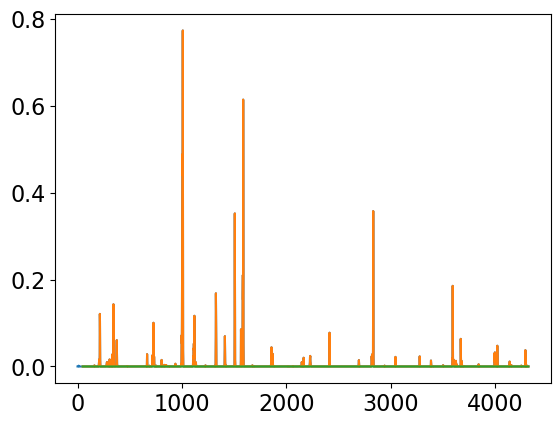

In [25]:
import matplotlib.pyplot as plt
plt.plot(testrun_numpy[0])
plt.plot(testrun_numpy[0][50:])



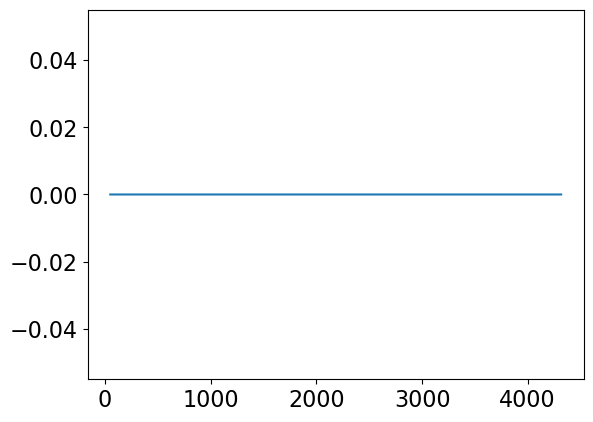

In [26]:
plt.plot(testrun_numpy[0] - testrun_numpy[0][50:])